## Resumen de la revisión 1 <a class="tocSkip"></a>

----

# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import math as mt
from math import factorial

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls_df = pd.read_csv('/datasets/megaline_calls.csv', sep=',')
mensajes_df = pd.read_csv('/datasets/megaline_messages.csv', sep=',')
internet_df = pd.read_csv('/datasets/megaline_internet.csv', sep = ',')
plans_df = pd.read_csv('/datasets/megaline_plans.csv', sep=',')
users_df = pd.read_csv('/datasets/megaline_users.csv', sep = ',')

## Preparar los datos

Disponemos de 5 tablas de datos:
    
- Tablas de Servicios: Tres de estas tablas corresponden a los servicios ofrecidos en el plan (internet, mensajes y datos). En estas tablas se encuentra información sobre el ID del usuario que utiliza el servicio, la fecha de uso y el consumo del servicio. Para internet, se mide en megabytes (MB), y para llamadas, en minutos. Cada fila de información incluye el ID correspondiente para identificar cada operación.


- Tabla de Planes: Esta tabla detalla la tarifa mensual en USD, el nombre del plan y los servicios que se ofrecen por un monto específico. La tabla especifica la cantidad de internet en megabytes, la cantidad de mensajes y el tiempo de llamadas en minutos. También incluye la tarifa adicional por cada minuto, GB o mensaje que exceda lo establecido en el plan.


- Tabla de Clientes: Contiene el ID único del usuario, que se utiliza para llevar el registro de su consumo. Además, incluye el nombre, apellido, edad, ciudad, fecha de registro, el nombre del plan contratado y, en caso de que el usuario haya dado de baja el plan, la fecha de baja.

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


##### Observaciones
- Se obserban 2 planes Surf y Ultimate.
- El plan surf consiste en una tarifa de  `$20` mensuales por 500 minutos, 50 mensajes y 15360mb con un costo adicional de `$10` por GB y 3 centavos por minuto o mensaje extra a lo mencionado en el plan. 
- El plan Ultimate consiste en una tarida de `$70` mensuales por 3000 minutos, 1000 sms y 30720mb con un costo adicional de `$7` por GB, 1 centavo por minuto o mensaje extra a lo convenido en el plan.
##### Problemas
- Inconsitencia unidades de medida: La cantidad de datos moviles por mes están medidos en mb y se cobran por cantidad en GB. Esto representa una incosistencia en los datos que puede causar confución y errores durante el análisis. 
- Tipos de Datos: El costo `usd_monthly_pay` y `usd_per_gb` son de tipo int y deberian manejarse como float debido a que el monto podria cambiar eventualmente y podria generar perdida de informacion si se conserva como entero y más adelante se agregan datos con valores decimales como centavos.
##### Soluciónes:
- Convertir los valores de `mb_per_month_included` a GB para mantener consistencia en las unidades de medida.
- Convertir las columnas `usd_monthly_pay` y `usd_per_gb` en tipo `float` con el metodo `astype()`.

## Corregir datos

Cambiar el tipo de dato a las columnas `usd_monthly_pay` y `usd_per_gb`

In [5]:
plans_df['usd_monthly_pay']= plans_df['usd_monthly_pay'].astype(float)
plans_df['usd_per_gb']= plans_df['usd_per_gb'].astype(float)

## Enriquecer los datos


Convertir la columna `mb_per_month_included` en `gb_per_month_included`

In [6]:
plans_df['mb_per_month_included'] = plans_df['mb_per_month_included']/1024
plans_df.rename(columns = {'mb_per_month_included':'gb_per_month_included'}, inplace=True)

Redondeo por exceso a los valores de `gb_per_month_included`

In [7]:
plans_df['gb_per_month_included'] = plans_df['gb_per_month_included'].apply(mt.ceil)

## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
print('Usuarios')
users_df.info()

Usuarios
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
users_df.sample(3)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
276,1276,Karmen,Carney,20,"Phoenix-Mesa-Chandler, AZ MSA",2018-02-14,surf,NaN
80,1080,Neal,Mcgee,45,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-08-03,surf,NaN
456,1456,Seymour,Olsen,66,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-06-02,ultimate,NaN


##### Observaciones
 En esta tabla se observan los atributos de cada usuario: 
- `user_id`: El número que identifica a cada usuario único
- `first_name` y `last_name`: Indican el nombre y apellido del usuario respectivamente, podian unirse en una sola columna, `full_name` para simplificarlos
- `age`: Indica la edad del usuario. Es importante verificar que estos valores sean razonables.
- `city`: Contiene información sobre el área metropolitana de residencia del cliente. Aunque contiene mucha información, es importante considerar si el nivel de precisión es suficiente para el análisis o si se necesita información más específica.
- `reg_date`: Contiene la fecha en desde la cual el cliente contrató el plan.
- `plan`: Indica si se contrató el plan  `surf` o `ultimate`.
- `churn_date`: Indica la fecha en la se da de baja o se cancela el plan o el servicio contratado. Los valores NaN indican usuarios que aún no han cancelado el servicio.
##### Problemas:
- Las columnas `reg_date` y `churn_date` son de tipo `object`, lo que podría permitir el ingreso de fechas en un formato incorrecto.
- Datos Ausentes en churn_date.
##### Soluciones:
- Para verifiacar que el formato de la fecha sea correcto lo mejor será cambiar el tipo de dato a las columnas `reg_date` y `churn_date` de `object` a `date`.
- Reconocer que los valores `NaN` son esperados para usuarios activos y manejarlos adecuadamente en el análisis.

Revisar si existen datos duplicados

In [10]:
users_df.duplicated().sum()

0

Verificar rango de edad

In [11]:
print('Rango de edad:',users_df['age'].min(), 'y',users_df['age'].max())

Rango de edad: 18 y 75


### Corregir los datos

Cambiar el tipo de dato a las columnas `reg_date` y `churn_date`

In [12]:
users_df['reg_date']= pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')
users_df['churn_date']= pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')
users_df['month'] = users_df['reg_date'].dt.month

### Enriquecer los datos

Fusionar las columnas correspondientes a nombre y apellido

In [13]:
# Combinar las columnas first_name y last_name almacenar los valores en la primera columna y renombrarla como full_name
users_df['first_name'] = users_df['first_name']+' ' + users_df['last_name']


In [14]:
users_df.rename(columns={'first_name':'full_name'}, inplace = True)

In [15]:
# Eliminar la columna last_name
users_df.drop(['last_name'], axis=1, inplace=True)

## Llamadas

In [16]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print('Llamadas')
calls_df.info()

Llamadas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [17]:
# Imprime una muestra de datos para las llamadas
calls_df.head(3)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48


##### Observaciones:
En la tabla se muestra la informacion de cada llamada:
- `id`: Identifica de manera única cada llamada, al parecer el id esta compuesto por el user_id un guión-bajo y un número adicional.
- `user_id`: Es una clave foranea de la tabla user_df, el número identifica qué usuario realizó la llamada.
- `call_date`: Indica la fecha en que se realizó la llamada en formato `yyyy-mm-dd` 
- `duration`: Indica la duracion de la llamada en minutos.
##### Problemas:
- El campo duration es de tipo float, lo cual podría causar problemas ya que los minutos generalmente se miden como números enteros o en segundos, y los decimales de un float no equivalen a fracciones de un minuto.
- Se pueden observar valores de de `0.00` en la colunmna `duration`, aunque estos valores podrían referirse a llamadas de prueba (llamar y colgar de inmediato). Independientemente si representan llamadas fallidas o de prueba, no aportan valor al análisis ya que no se realiza un cobro de servicio por estas llamadas.
- Adicionalmente, podría ser más específico el nombre de la columna `duration`, ya que no especifica la unidad de medida.
- La columna `call_date` es de tipo `object`, lo que podría permitir el ingreso de fechas en un formato incorrecto.
##### Soluciones:
- Cambiar el tipo de dato de la columna `duration` a un formato más adecuado. Dado que la tarifa se calcula redondeando hacia arriba al minuto más cercano, lo más apropiado sería almacenar el valor como un entero, realizando el redondeo por exceso.
- Lo más conveniente para el este caso en donde la columna `duration` tiene valores `0.00` es eliminar estos registros.
- Renombrar la columna `duration` a `minutes`
- Realizar una validación adicional de la columna `call_date` para asegurarse de que todas las fechas son válidas y están en el formato correcto. Para esto lo mejor será cambiar el tipo de dato a la columna de `object` a `datetime`.

### Corregir los datos

Cambiar el tipo de dato a la columna `duration` a `int` y la columna `call_date` a `datetime`

In [18]:
calls_df['duration'] = mt.ceil(calls_df['duration'])

In [19]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')

Eliminar los registros con el valor de `duration` igual a 0

In [20]:
calls_df = calls_df[calls_df['duration']!= 0]

### Enriquecer los datos

Extraer solo el mes de la columna `call_date` y almacenarlo en una nueva columna

In [21]:
calls_df['month'] = calls_df['call_date'].dt.month

Renombrar la columna `duration`

In [22]:
calls_df.rename(columns= {'duration': 'minutes'}, inplace=True)

In [23]:
calls_df.head(3)

,id,user_id,call_date,minutes,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12


## Mensajes

In [24]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
print('Mensajes')
mensajes_df.info()

Mensajes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [25]:
# Imprime una muestra de datos para los mensajes
mensajes_df.tail(3)

,id,user_id,message_date
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24
76050,1497_613,1497,2018-12-23


##### Observaciones:
En la tabla se muestra la informacion de cada mensaje:
- `id`: Identifica de manera única cada mensaje, el id esta compuesto por el user_id y un guión-bajo seguido de un número adicional.
- `user_id`: Es una clave foranea de la tabla user_df, el número identifica al usuario emisor del mensaje.
- `message_date`: Indica en que fecha se envió el mensaje en formato `yyyy-mm-dd` 
- No se observan problemas en la estructura o en los datos, solo para verificar correctamente el formato lo mejor será cambiar el tipo de dato de la columna `message_date` a `datetime`

### Corregir los datos

Cambiar el tipo de dato de `message_date` a datetime

In [26]:
mensajes_df['message_date'] = pd.to_datetime(mensajes_df['message_date'], format='%Y-%m-%d')

### Enriquecer los datos

Extraer el solo el mes de la fecha en la que se envió el mensaje y almacenarlo en una nueva columna

In [27]:
mensajes_df['month'] = mensajes_df['message_date'].dt.month

## Internet

In [28]:
# Imprime la información general/resumida sobre el DataFrame de internet
print('Internet')
internet_df.info()

Internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [29]:
# Imprime una muestra de datos para el tráfico de internet
internet_df.head(3)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40


##### Observaciones:
- `id`: Identificador único de cada sesión de uso de datos. Parece estar compuesto por user_id seguido de un guion bajo y un número adicional.
- `user_id`: Identificador del usuario que ha utilizado los datos.
- `session_date`: Fecha en la que se registró el uso de datos, en formato yyyy-mm-dd.
- `mb_used`: Cantidad de datos utilizados en MB (megabytes) durante la sesión.
##### Problemas: 
- Se observan valores de 0.00 en mb_used, lo que podría indicar sesiones donde no se utilizó ningún dato. Estos registros podrían ser irrelevantes para nuestro análisis.
- La columna `session_date` es de tipo `object`, lo que podría permitir el ingreso de fechas en un formato incorrecto. 
##### Solucion: 
- Convertir la columna `session_date` a un tipo de dato `datetime` para asegurar la consistencia y facilitar el análisis temporal.
- Eliminar las filas con `mb_used` igual a 0.00

### Corregir los datos

Eliminar datos que no aportan información 

In [30]:
# Eliminar las filas con 'mb_used' igual a 0.00
internet_df= internet_df[internet_df['mb_used'] != 0]

In [31]:
# Cambiar el tipo de dato de la columna 'session_date'
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format= '%Y-%m-%d')

### Enriquecer los datos

Extraer el solo el mes de la columna de `session_date`.

In [32]:
internet_df['month'] = internet_df['session_date'].dt.month

## Estudiar las condiciones de las tarifas

In [33]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20.0,10.0,0.03,0.03,surf
1,1000,30,3000,70.0,7.0,0.01,0.01,ultimate


## Agregar datos por usuario

Agregar los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.

In [34]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_user_per_month = calls_df.groupby(['user_id','month'])['call_date'].count().reset_index(name='count_calls')
calls_user_per_month.sample(2)

,user_id,month,count_calls
967,1209,8,9
1635,1361,7,42


In [35]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_user_per_month = calls_df.groupby(['user_id','month'])['minutes'].sum().reset_index()
minutes_user_per_month.sample(3)

,user_id,month,minutes
1623,1359,3,480
529,1113,12,522
413,1088,6,242


In [36]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
sms_user_per_month = mensajes_df.groupby(['user_id', 'month'])['message_date'].count().reset_index(name= 'count_sms')
sms_user_per_month.sample(3)

,user_id,month,count_sms
206,1062,12,9
694,1188,9,32
1623,1444,10,54


In [37]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
data_user_per_month = internet_df.groupby(['user_id','month'])['mb_used'].sum().reset_index()
# Transformar el consumo de datos MB a GB
data_user_per_month['gb_used'] = data_user_per_month['mb_used']/1024
# Redondear el monto de Gigas consumidos hacia arriba
data_user_per_month['gb_used'] = data_user_per_month['gb_used'].apply(mt.ceil)
data_user_per_month.sample()

,user_id,month,mb_used,gb_used
2000,1432,10,8402.19,9


In [38]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
consumo_user_month= calls_user_per_month.merge(minutes_user_per_month, 
                                               on=['user_id','month'], 
                                               how='outer')

consumo_user_month = consumo_user_month.merge(sms_user_per_month, 
                                              on=['user_id','month'],
                                              how ='outer')

consumo_user_month = consumo_user_month.merge(data_user_per_month,
                                              on=['user_id','month'],
                                              how='outer')
# Elimina las columnas adicionales de month
consumo_user_month.drop('mb_used', axis=1, inplace= True)

In [39]:
# Unir el DF users_df para obtener la informacion del plan contratado por usuario
plan_user = users_df[['user_id','plan','city']]
consumo_user_month = consumo_user_month.merge(plan_user, on= 'user_id', how= 'outer')
#consumo_user_month.sample()

In [40]:
# Añade la información de la tarifa
consumo_user_month = consumo_user_month.merge(plans_df, left_on= 'plan', right_on='plan_name', how= 'outer')

In [41]:
consumo_user_month.drop('plan_name', axis=1, inplace = True)

In [42]:
consumo_user_month

,user_id,month,count_calls,minutes,count_sms,gb_used,plan,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30,3000,70.0,7.0,0.01,0.01
1,1006,11.0,2.0,10.0,15.0,3.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30,3000,70.0,7.0,0.01,0.01
2,1006,12.0,7.0,59.0,139.0,32.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",1000,30,3000,70.0,7.0,0.01,0.01
3,1008,10.0,54.0,476.0,21.0,17.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30,3000,70.0,7.0,0.01,0.01
4,1008,11.0,50.0,446.0,37.0,24.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",1000,30,3000,70.0,7.0,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,NaN,NaN,NaN,NaN,surf,"Cincinnati, OH-KY-IN MSA",50,15,500,20.0,10.0,0.03,0.03
2299,1307,NaN,NaN,NaN,NaN,NaN,surf,"Boston-Cambridge-Newton, MA-NH MSA",50,15,500,20.0,10.0,0.03,0.03
2300,1319,NaN,NaN,NaN,NaN,NaN,surf,"Colorado Springs, CO MSA",50,15,500,20.0,10.0,0.03,0.03
2301,1378,NaN,NaN,NaN,NaN,NaN,surf,"Denver-Aurora-Lakewood, CO MSA",50,15,500,20.0,10.0,0.03,0.03


In [43]:
# Calcular el consumo extra mensual de cada usuario
extra_consum_month = pd.DataFrame()
extra_consum_month['month'] = consumo_user_month['month']
extra_consum_month['plan'] = consumo_user_month['plan']
extra_consum_month['city'] = consumo_user_month['city']
extra_consum_month['extra_minutes'] = np.maximum(0, consumo_user_month['minutes'] - consumo_user_month['minutes_included'])
extra_consum_month['extra_messages'] = np.maximum(0, consumo_user_month['count_sms'] - consumo_user_month['messages_included'])
extra_consum_month['extra_gb'] = np.maximum(0, consumo_user_month['gb_used'] - consumo_user_month['gb_per_month_included']) 

In [45]:
# Calcula el ingreso mensual para cada usuario
extra_consum_month['extra_minutes_cost'] = extra_consum_month['extra_minutes']* consumo_user_month['usd_per_minute']
extra_consum_month['extra_messages_cost'] = extra_consum_month['extra_messages'] * consumo_user_month['usd_per_message']
extra_consum_month['extra_gb_cost'] = extra_consum_month['extra_gb'] * consumo_user_month['usd_per_gb']

In [46]:
extra_consum_month['total_cost_usd'] = np.maximum(0, extra_consum_month['extra_minutes_cost'] + extra_consum_month['extra_messages_cost'] + extra_consum_month['extra_gb_cost'] + consumo_user_month['usd_monthly_pay'])

Se observan filas con valores ausentes en todas las columnas de consumo. Probablemente corresponden a usuarios que contrataron el un plan pero no han consumido datos. Esto podria producir errores en el analisis asi que será mejor rellenar los datos.

In [47]:
extra_consum_month.isna().sum()

month                   10
plan                     0
city                     0
extra_minutes           47
extra_messages         497
extra_gb                26
extra_minutes_cost      47
extra_messages_cost    497
extra_gb_cost           26
total_cost_usd         545
dtype: int64

In [48]:
# Llena los valores NaN con 0 
consumo_user_month = consumo_user_month.fillna(0)
extra_consum_month = extra_consum_month.fillna(0)
extra_consum_month = extra_consum_month[extra_consum_month['total_cost_usd']!=0]
# Eliminar las filas con month = 0 ya que estas no contienen informacion relevante para el analisis
consumo_user_month = consumo_user_month[consumo_user_month['month']!= 0]
# Convierte las columnas de vuelta a enteros
consumo_user_month['month'] = consumo_user_month['month'].astype(int)
consumo_user_month['count_calls'] = consumo_user_month['count_calls'].astype(int)
consumo_user_month['minutes'] = consumo_user_month['minutes'].astype(int)
consumo_user_month['count_sms'] = consumo_user_month['count_sms'].astype(int)
consumo_user_month['gb_used'] = consumo_user_month['gb_used'].astype(int)
extra_consum_month['month'] = consumo_user_month['month'].astype(int)
extra_consum_month['plan'] = consumo_user_month['plan']
extra_consum_month['extra_minutes'] = extra_consum_month['extra_minutes'].astype(int)
extra_consum_month['extra_messages'] = extra_consum_month['extra_messages'].astype(int)
extra_consum_month['extra_gb'] = extra_consum_month['extra_gb'].astype(int)

In [50]:
consumo_user_month.sample(3)

,user_id,month,count_calls,minutes,count_sms,gb_used,plan,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
1404,1212,12,30,263,35,13,surf,"Austin-Round Rock-Georgetown, TX MSA",50,15,500,20.0,10.0,0.03,0.03
2092,1425,12,28,246,28,18,surf,"Las Vegas-Henderson-Paradise, NV MSA",50,15,500,20.0,10.0,0.03,0.03
2227,1491,4,6,44,6,0,surf,"Grand Rapids-Kentwood, MI MSA",50,15,500,20.0,10.0,0.03,0.03


In [51]:
extra_consum_month.sample(3)

,month,plan,city,extra_minutes,extra_messages,extra_gb,extra_minutes_cost,extra_messages_cost,extra_gb_cost,total_cost_usd
655,7,ultimate,"Fresno, CA MSA",0,0,0,0.0,0.0,0.0,70.0
380,9,ultimate,"Cleveland-Elyria, OH MSA",0,0,0,0.0,0.0,0.0,70.0
365,7,ultimate,"Los Angeles-Long Beach-Anaheim, CA MSA",0,0,0,0.0,0.0,0.0,70.0


## Estudia el comportamiento de usuario

### Llamadas

In [52]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
avg_call_duration_by_plan_month = consumo_user_month.pivot_table(index='month', columns='plan',  values='minutes', aggfunc='mean')

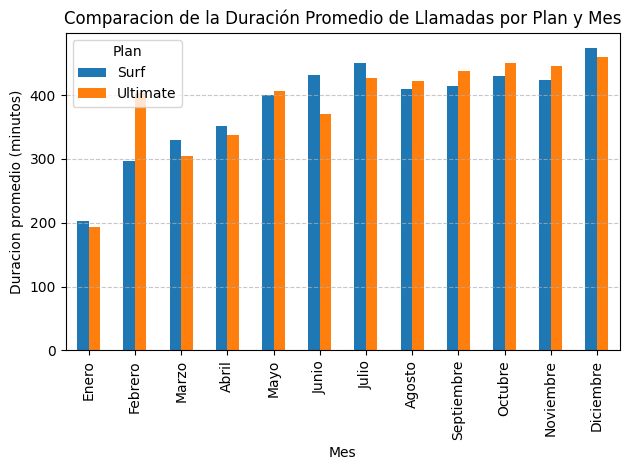

In [53]:
# Lista de nombres de meses
month_names = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
avg_call_duration_by_plan_month.plot( ylabel= 'Duracion promedio (minutos)',
                                     xlabel = 'Mes',
                                     kind= 'bar',title= 'Comparacion de la Duración Promedio de Llamadas por Plan y Mes')
# Cambiar etiquetas de x por los nombres de los meses
plt.xticks(ticks=range(len(month_names)), labels=month_names)
plt.legend(['Surf', 'Ultimate'],title='Plan', fontsize=10)
# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

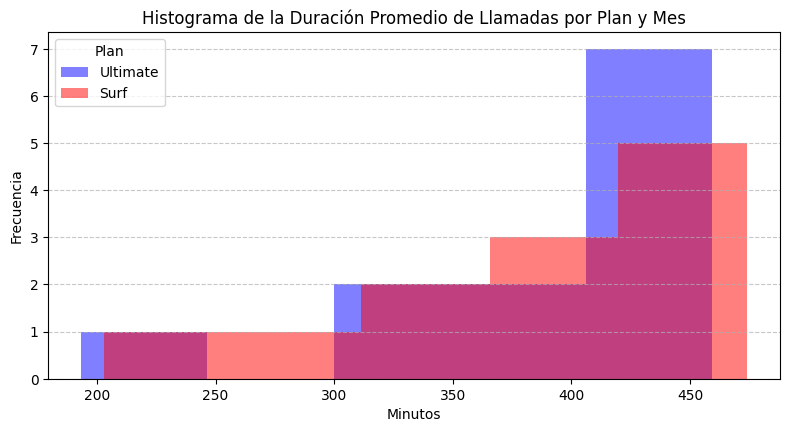

In [54]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# calcular la cantidad adecuada de bins a utilizar
n_bins = int(np.ceil(np.log2(len(avg_call_duration_by_plan_month)) + 1))
plt.figure(figsize=(8, 4))
avg_call_duration_by_plan_month['ultimate'].plot(kind='hist', bins=n_bins, alpha=0.5, color='blue', label='Ultimate')
avg_call_duration_by_plan_month['surf'].plot(kind='hist', bins=n_bins, alpha=0.5, color='red', label='Surf')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Plan', fontsize=10)
plt.title('Histograma de la Duración Promedio de Llamadas por Plan y Mes')
plt.ylabel('Frecuencia')
plt.xlabel('Minutos')
plt.show()

In [55]:
# Calcula la media y la varianza de la duración mensual de llamadas.
var_media_calls = pd.DataFrame(index=['media', 'varianza'])
var_media_calls['surf'] = [avg_call_duration_by_plan_month['surf'].mean(), np.var(avg_call_duration_by_plan_month['surf'])]
var_media_calls['ultimate'] = [avg_call_duration_by_plan_month['ultimate'].mean(), 
                               np.var(avg_call_duration_by_plan_month['ultimate'])]
var_media_calls.head()

,surf,ultimate
media,384.469691,387.999742
varianza,5369.551952,5472.540904


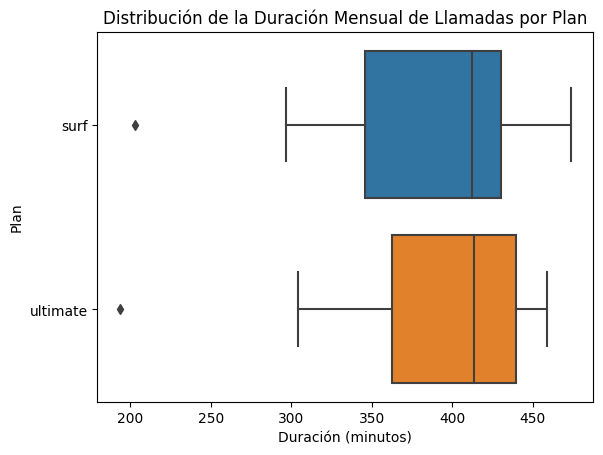

In [56]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
month_duration_calls = consumo_user_month.groupby(['plan','month'])['minutes'].mean().reset_index(name='duration')

# Graficar usando seaborn
sns.boxplot(y='plan', x='duration', data=month_duration_calls)
#plt.yticks('Surf','Ultimate')
plt.xlabel('Duración (minutos)')
plt.ylabel('Plan')
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.show()
#print(avg_call_duration_by_plan_month.head())
#print('=========================================')
#print(month_duration_calls.head()) 

- El comportamiento del consumo de minutos es similar en ambos planes, aunque no idéntico. Ambos planes tienen una mayor frecuencia de uso en el rango de 400 a 450 minutos. Sin embargo, el plan `Ultimate` tiene una mayor concentración de usuarios en este rango, lo que sugiere que los usuarios de este plan tienden a usar más minutos.
- Los usuarios del plan `Surf` están mayormente distribuidos en los rangos de 200 a 350, mientras que los usuarios de `Ultimate` tienden a estar concentrados en los rangos más altos.
- Aunque es más frecuente que los usuarios de `Ultimate` esten entre los 400 y 450 minutos existen clientes del plan `Surf` que utilizan al rededor de 450 y 470 minutos al mes
- Ninguno de los planes supera los 500 minutos en llamada mensualmente. Seria recomendable bajar la cantidad de minutos incluido en ambos planes.
- En enero ambos planes parten con un promedio de minutos mas bajo para el plan `Surf` este es ligeramente mas alto que el de `Ultimate`. `Ultimate` tiene un gran alza en febrereo pero vuelve a bajar drasticamente en marzo, desde ahi aumenta gradualmente en abril y mayo, baja otra vez en junio y sube en julio, los meses siguientes sube y baja alternadamente pero se mantiene pos sobre los 400 minutos.
- `Surf` por otro lado tubo un gran aumento de la duracion de llamadas de enero a febrero y desde ahí aumentó ligeramente cada mes hasta Julio, de Julio a agosto se redujo la duracion promedio de llamadas pero aun asi no decendio de los 400 minutos, aumentó nuevamente en septiembre y octubre, bajó en noviembre y aumentó a casi 500 en diciembre

### Mensajes

In [57]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan 
avg_monthly_messages_per_plan = consumo_user_month.pivot_table(index='month', 
                                                               columns='plan', values='count_sms', aggfunc='mean')

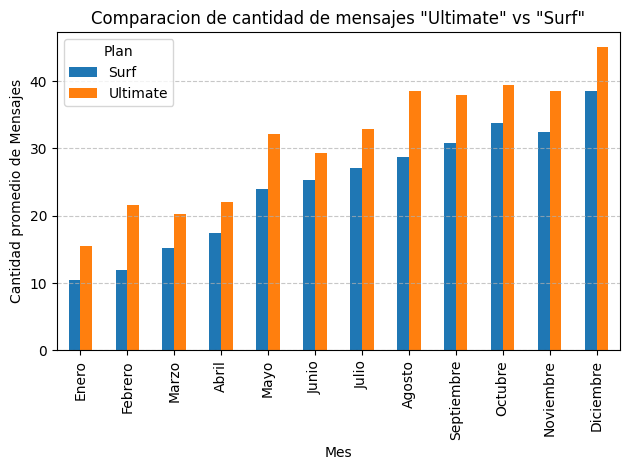

In [58]:
# Traza un gráfico de barras para visualizar la diferencia.
avg_monthly_messages_per_plan.plot(kind='bar', ylabel= 'Cantidad promedio de Mensajes',
                                     xlabel = 'Mes',
                                     title= 'Comparacion de cantidad de mensajes "Ultimate" vs "Surf"')
# Cambiar etiquetas de x por los nombres de los meses
plt.xticks(ticks=range(len(month_names)), labels=month_names)
plt.legend(['Surf', 'Ultimate'], title='Plan', fontsize=10)
# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

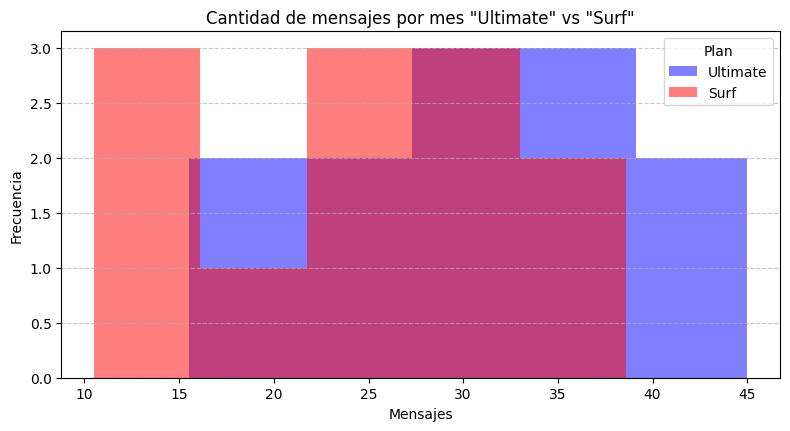

In [59]:
# Compara la cantidad de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# calcular la cantidad adecuada de bins a utilizar
n_bins = int(np.ceil(np.log2(len(avg_monthly_messages_per_plan)) + 1))
plt.figure(figsize=(8, 4))
avg_monthly_messages_per_plan['ultimate'].plot(kind='hist', bins=n_bins, alpha=0.5, color='blue', label='Ultimate')
avg_monthly_messages_per_plan['surf'].plot(kind='hist', bins=n_bins, alpha=0.5, color='red', label='Surf')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Plan', fontsize=10)
plt.title('Cantidad de mensajes por mes "Ultimate" vs "Surf"')
plt.ylabel('Frecuencia')
plt.xlabel('Mensajes')
plt.show()

In [60]:
# Calcula la media y la varianza de la cantidad mensual de  mensajes.
var_media_sms = pd.DataFrame(index=['media', 'varianza'])
var_media_sms['surf'] = [avg_monthly_messages_per_plan['surf'].mean(), np.var(avg_monthly_messages_per_plan['surf'])]
var_media_sms['ultimate'] = [avg_monthly_messages_per_plan['ultimate'].mean(), 
                             np.var(avg_monthly_messages_per_plan['ultimate'])]
var_media_sms.head()

,surf,ultimate
media,24.656000,31.089497
varianza,75.064776,80.074466


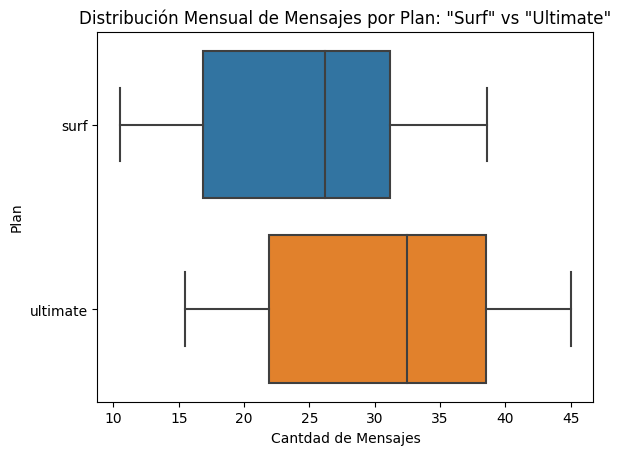

In [61]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad mensual de mensajes
month_sms = consumo_user_month.groupby(['plan','month'])['count_sms'].mean().reset_index(name='cant_sms')

# Graficar usando seaborn
sns.boxplot(y='plan', x='cant_sms', data= month_sms)
plt.xlabel('Cantdad de Mensajes')
plt.ylabel('Plan')
plt.title('Distribución Mensual de Mensajes por Plan: "Surf" vs "Ultimate"')
plt.show()

- Los usuarios del plan `Ultimate` tienden a enviar más mensajes que los del plan 'Surf', aunque su consumo no se aproxima al límite desproporcional de 1000 mensajes incluidos en el plan. El rango de uso para este plan varía aproximadamente entre 16 y 45 mensajes mensuales."
- Los usuarios del plan `Surf` no utilizan más de 40 mensajes al mes.
- Sería conveniente reducir la cantidad de mensajes incluidos en ambos planes, ya que ningún usuario necesita más de 50 mensajes mensuales según los datos
- Podría considerarse la creación de un nuevo plan para los usuarios que envían entre 10 y 15 mensajes, ya que representan una proporción considerable de los usuarios del plan 'Surf'
- El plan `Surf` mantiene un alza constante desde enero a octubre, el mes de noviembre tuvo una ligera baja y vuelve a subir la cantidad de mensajes en diciembre.
- El comportamiento de los usuarios de `Ultimate` es más variado al lo largo del año, en enero hay menor actividad, reapunta en febrero, pero vuelve a bajar ligeramente en marzo, y sube nuevamente en abril y mayo, y asi se mantiene subiendo y bajando hasta diciembre, donde aumenta significativamente el promedio de mensajes. La baja de consumo durante el año fueron menores a las alzas.

### Internet

In [62]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
avg_monthly_data_per_plan = consumo_user_month.pivot_table(index='month', columns='plan', values='gb_used', aggfunc='mean')
#avg_monthly_data_per_plan

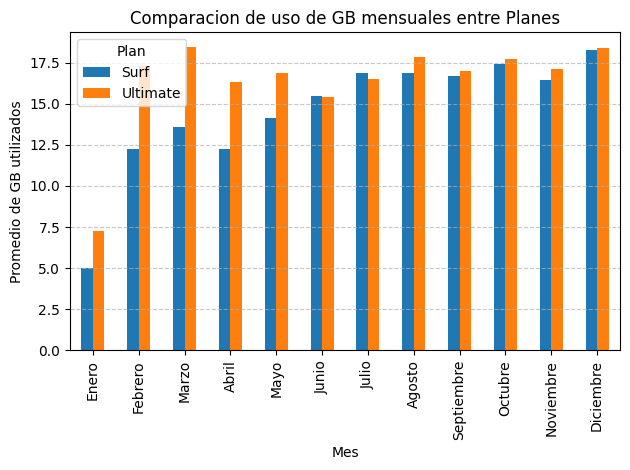

In [63]:
# Traza un gráfico de barras para visualizar la diferencia.
avg_monthly_data_per_plan.plot(kind='bar', ylabel= 'Promedio de GB utilizados',
                                     xlabel = 'Mes',
                                     title= 'Comparacion de uso de GB mensuales entre Planes')
# Cambiar etiquetas de x por los nombres de los meses
plt.xticks(ticks=range(len(month_names)), labels=month_names)
plt.legend(['Surf', 'Ultimate'], title='Plan', fontsize=10)
# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

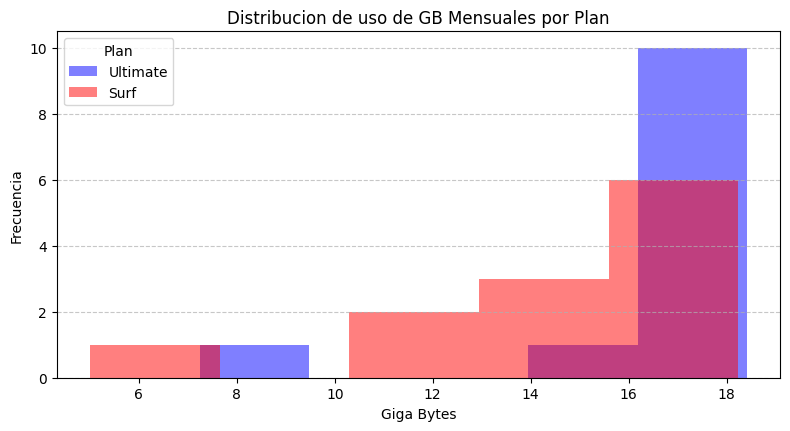

In [64]:
# Compara el número de GB mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# calcular la cantidad adecuada de bins a utilizar
n_bins = int(np.ceil(np.log2(len(avg_monthly_data_per_plan)) + 1))
plt.figure(figsize=(8, 4))
avg_monthly_data_per_plan['ultimate'].plot(kind='hist', bins=n_bins, alpha=0.5, color='blue', label='Ultimate')
avg_monthly_data_per_plan['surf'].plot(kind='hist', bins=n_bins, alpha=0.5, color='red', label='Surf')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Plan', fontsize=10)
plt.title('Distribucion de uso de GB Mensuales por Plan')
plt.ylabel('Frecuencia')
plt.xlabel('Giga Bytes')
plt.show()

In [65]:
# Calcula la media y la varianza de la cantidad mensual de GB utilizados.
var_media_gb = pd.DataFrame(index=['media', 'varianza'])
var_media_gb['surf'] = [avg_monthly_data_per_plan['surf'].mean(), np.var(avg_monthly_data_per_plan['surf'])]
var_media_gb['ultimate'] = [avg_monthly_data_per_plan['ultimate'].mean(), np.var(avg_monthly_data_per_plan['ultimate'])]
var_media_gb

,surf,ultimate
media,14.594808,16.346165
varianza,12.067831,8.201410


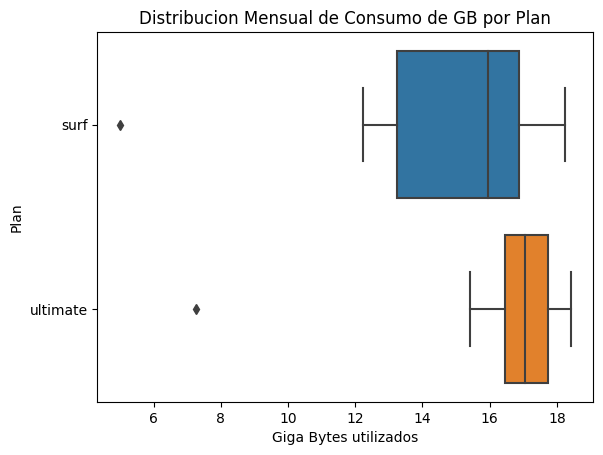

In [66]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de mensajes
month_gb = consumo_user_month.groupby(['plan','month'])['gb_used'].mean().reset_index(name='avg_gb')

# Graficar usando seaborn
sns.boxplot(y='plan', x='avg_gb', data=month_gb)
plt.xlabel('Giga Bytes utilizados')
plt.ylabel('Plan')
plt.title('Distribucion Mensual de Consumo de GB por Plan')
plt.show()

- El uso de Internet en por los usuarios de "Ultimate" se mantiene constante a lo largo de los meses en el rango de 16 a 18 GB
- Los usuarios del plan Ultimate generalmente tienen un uso de datos más alto que los usuarios de Surf durante la mayoría de los meses.
- Hay un pico notable en el uso de GB en agosto para el plan Ultimate, que supera ligeramente al uso en otros meses.
- En enero, el uso de datos en el plan Surf es significativamente menor en comparación con los otros meses y con el plan Ultimate.
- A partir de febrero, el uso de datos de Surf aumenta y se mantiene relativamente constante, aunque siempre por debajo de Ultimate.
- Para el plan Ultimate, se observa un uso más constante a lo largo del año, con pequeñas variaciones.
- Ambos planes muestran un aumento en el uso de datos en los meses de verano, siendo agosto el mes con el mayor consumo para Ultimate.
- Se obserba en el historiograma que al igual que con los minutos y los mensajes hay un grupo de usuarios que tiene un consumo de datos mucho más bajo de lo esperado entre 5 y 9 GB

- Los usuarios de Surf utilizan habitualmente entre 12 y 18 GB, mientras que el rango de consumo de los usuarios de ultimate esta concentrado mayormente entre los 16 y 18 GB mensuales.

## Ingreso

In [67]:
# Compara los ingresos generados por usuarios por plan. Traza un gráfico de barras para visualizarla.
avg_income_by_plan_month = extra_consum_month.pivot_table(index='month', columns='plan', 
                                                          values='total_cost_usd', aggfunc='mean')

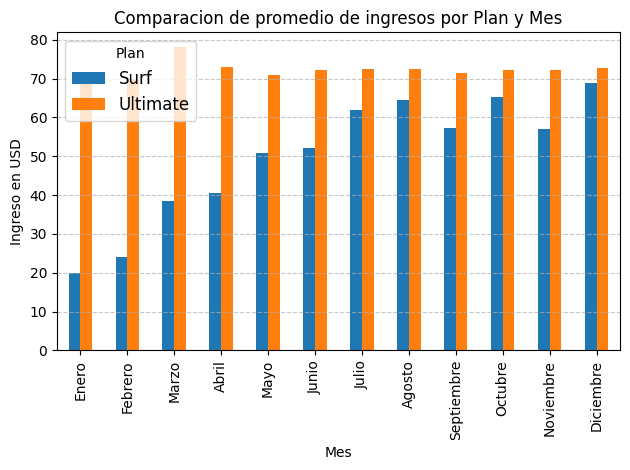

In [68]:
avg_income_by_plan_month.plot(ylabel= 'Ingreso en USD',
                                     xlabel = 'Mes',
                                     kind= 'bar',
                                     title= 'Comparacion de promedio de ingresos por Plan y Mes')
# Cambiar etiquetas de x por los nombres de los meses
plt.xticks(ticks=range(len(month_names)), labels=month_names)
plt.legend(['Surf', 'Ultimate'],title='Plan', fontsize=12, )
# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

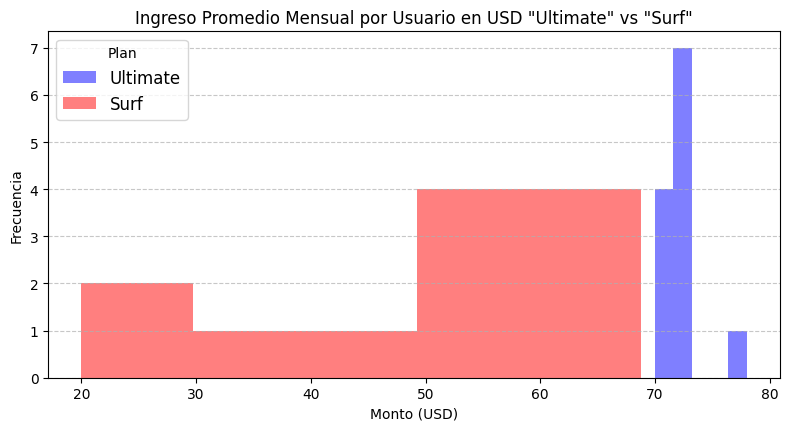

In [69]:
# Compara los ingresos mensuales promedio por usuario de cada plan. Traza un histograma.
# calcular la cantidad adecuada de bins a utilizar
n_bins = int(np.ceil(np.log2(len(avg_income_by_plan_month)) + 1))
plt.figure(figsize=(8, 4))
avg_income_by_plan_month['ultimate'].plot(kind='hist', bins=n_bins, alpha=0.5, color='blue', label='Ultimate')
avg_income_by_plan_month['surf'].plot(kind='hist', bins=n_bins, alpha=0.5, color='red', label='Surf')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Plan', fontsize=12)
plt.title('Ingreso Promedio Mensual por Usuario en USD "Ultimate" vs "Surf"')
plt.ylabel('Frecuencia')
plt.xlabel('Monto (USD)')
plt.show()


In [70]:
# Calcula la media y la varianza del ingreso promedio mensual por usuario.
var_media_usd = pd.DataFrame(index=['media', 'varianza'])
var_media_usd['surf'] = [avg_income_by_plan_month['surf'].mean(), np.var(avg_income_by_plan_month['surf'])]
var_media_usd['ultimate'] = [avg_income_by_plan_month['ultimate'].mean(), np.var(avg_income_by_plan_month['ultimate'])]
var_media_usd.head()

,surf,ultimate
media,50.052760,72.283602
varianza,236.903215,3.875544


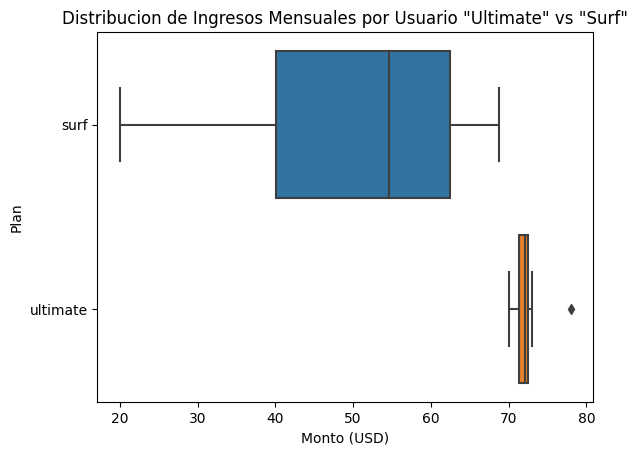

In [71]:
# Traza un diagrama de caja para visualizar la distribución del mensual de ingresos por cliente
month_usd_plan = extra_consum_month.groupby(['plan','month'])['total_cost_usd'].mean().reset_index(name='avg_usd')

# Graficar usando seaborn
sns.boxplot(y='plan', x='avg_usd', data=month_usd_plan)
plt.xlabel('Monto (USD)')
plt.ylabel('Plan')
plt.title('Distribucion de Ingresos Mensuales por Usuario "Ultimate" vs "Surf"')
plt.show()

- El plan `Ultimate`se mantiene al rededor `$70` los meses de enero y febrero, el mes de marzo casi llega a los `$80`, y baja ligeramente el mes de abril, las fluctuaciones de ingreso no son muy grandes entre cada mes.
- Por el contrario el promedio de ingresos del plan `Surf` quizas le deba su nombre a las olas que genera con la fluctuacion de ingesos al lo largo del año. El mes de enero un ingreso promedio de `$20`, en febrero aumenta al rededor de `$15`, en marzo ocurrio un aumento similar, bajó un par de dolares en abril y desde mayo a agosto hubo un alsa constante de ingresos, los siguentes 3 meses los ingresos promedio suben y bajan aproximadamente `$5`, por ulmimo el mes de diciembre tiene un alza de mas de `$10` lo con lo que alcanza los `$70` casi igualando los ingresos de `Ultimate` de ese mes.
- Surf tiene una distribución más amplia, con ingresos que van desde aproximadamente `$20` hasta casi `$70` .
- Ultimate tiene una distribución más concentrada alrededor de los $70 USD, lo que indica que la mayoría de los usuarios están generando ingresos en este rango. 
- La frecuencia de ingresos en Surf está más dispersa, con picos notables en los intervalos de 40-50 USD y 50-60 USD.
- Ultimate muestra un pico en el intervalo de ingresos más alto, indicando que la mayoría de sus usuarios generan ingresos cercanos a los `$70` .


## Prueba las hipótesis estadísticas

- H0 (Hipótesis Nula):  No hay diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.
- H1 (Hipótesis Alternativa): Hay una diferencia en los ingresos promedio entre los usuarios de los planes Ultimate y Surf.
- Umbral de significacion: 5%

In [72]:
# Prueba las hipótesis
avg_income_surf = avg_income_by_plan_month['surf']
avg_income_ultimate = avg_income_by_plan_month['ultimate']

alpha = 0.05
results = st.ttest_ind(avg_income_surf, avg_income_ultimate, equal_var=False) 
print('Estadístico t:',results)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio de los planes.")
else:
    print("No rechazamos la hipótesis nula. No hay una diferencia significativa entre los ingresos promedio de los planes.")

Estadístico t: Ttest_indResult(statistic=-4.751636114631202, pvalue=0.0005473491793640881)
Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio de los planes.


- H0 (Hipótesis Nula): El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.
- H1 (Hipótesis Alternativa): El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.
- Umbral de significacion: 5%

In [73]:
# Filtrar datos de interés
ny_nj_area = ['New York-Newark-Jersey City, NY-NJ-PA MSA', 'Albany-Schenectady-Troy, NY MSA','Buffalo-Cheektowaga, NY MSA']
# Filtrar usuarios del área NY-NJ
ny_nj_income  = extra_consum_month[extra_consum_month['city'].isin(ny_nj_area)]
# Filtrar usuarios de otras áreas
other_income = extra_consum_month[~extra_consum_month['city'].isin(ny_nj_area)]
# Obtener el ingreso promedio mensual por plan para NY-NJ
ny_nj_income = ny_nj_income.pivot_table(index='month', columns='plan', 
                                                          values='total_cost_usd', aggfunc='mean')
ny_nj_income.fillna(0,inplace=True)
# Obtener el ingreso promedio mensual por plan para otras areas 
other_income = other_income.pivot_table(index='month', columns='plan', 
                                                      values='total_cost_usd', aggfunc='mean')
other_income.fillna(0,inplace=True)

In [74]:
# Prueba las hipótesis
print('varianzas NY-NJ:',np.var(ny_nj_income))
print('--------------------------------------')
print(np.var(other_income))
print('----------------------------------------')
results_2 = st.ttest_ind(ny_nj_income, other_income, equal_var = False)
if results.pvalue < alpha:
     print("Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio entre el area de NY-NJ y las otras regiones")
else:
    print("No rechazamos la hipótesis nula. No hay suficiente evidencia para afirmar que los ingresos promedio son diferentes.")

varianzas NY-NJ: plan
surf        163.714304
ultimate    838.003596
dtype: float64
--------------------------------------
plan
surf        257.697794
ultimate      4.126986
dtype: float64
----------------------------------------
Rechazamos la hipótesis nula. Hay una diferencia significativa en los ingresos promedio entre el area de NY-NJ y las otras regiones


## Conclusión general

- El plan Ultimate genera más ingresos que el plan Surf, pero no parece ser la opción más óptima para muchos usuarios. En primer lugar, los usuarios de este plan raramente superan los límites de mensajes o minutos establecidos, y solo en pocas ocasiones exceden los límites de datos. Esto sugiere que la cantidad de minutos y mensajes ofrecidos en el plan Ultimate podría ser desproporcionada y poco útil para la mayoría de los usuarios.

- Por otro lado, los usuarios del plan Surf muestran una amplia variedad de patrones de consumo, desde aquellos que utilizan menos de la mitad de los datos incluidos en el plan, hasta quienes consumen casi la misma cantidad de datos que los usuarios del plan Ultimate.

- Considerando lo anterior, se podría evaluar la creación de un nuevo plan para los usuarios con un consumo de datos más bajo. Adicionalmente, se debería considerar reducir la cantidad de datos ofrecidos en el plan Ultimate, ya que, según los patrones de consumo observados, podría ser más rentable para algunos usuarios optar por el plan Surf y pagar la tarifa adicional por consumo extra.

- El consumo de servicios varía a lo largo del año. En febrero, se observó un aumento significativo en el consumo de datos, con fluctuaciones posteriores que muestran una tendencia al alza en el resto del año.

- Es crucial revisar los datos antes y después de unir columnas, ya que este proceso puede introducir valores nulos en varias columnas. Es importante manejar estos datos con cuidado al decidir si reemplazar o eliminar estos valores nulos.